# spacetrackのテスト その3 (gp API編)

同じ事を gp APIで取得したデータでもやってみる。
基本的にほとんど同じ。

- EPOCHにマイクロ秒まで入るので、そのままdatetimeに変換できる。
- 項目名の変更 (APOAPSIS、PERIAPSIS など)
- 項目の追加 (CREATION_DATE、LAUNCH_DATE、COUNTRY_CODE など)

In [1]:
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
from datetime import datetime
import numpy as np
import pandas as pd
import time
import json
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# userid and password are set in here
import spacetrackaccount
# print("Login with " + spacetrackaccount.userid)

In [4]:
st = SpaceTrackClient(spacetrackaccount.userid, spacetrackaccount.password)

In [5]:
def mycallback(until):
    duration = int(round(until - time.monotonic()))
    print('Sleeping for {:d} seconds.'.format(duration))

st.callback = mycallback

In [6]:
# gp APIを用いてHinodeの軌道データをJSON形式でダウンロード (既にダウンロード済みの場合はそれを使う)
norad_cat_id = 29479
file = 'download/gp_{}_all.json'.format(norad_cat_id)
if not os.path.isfile(file):
    print('Downloading new data')
    data = st.gp_history(norad_cat_id=norad_cat_id, orderby='epoch', format='json')
    with open(file, 'w') as fp:
        fp.write(data)
    df = pd.read_json(data, convert_dates = ['EPOCH', 'CREATION_DATE'])
else:
    print('Using pre-existing data')
    df = pd.read_json(file, convert_dates = ['EPOCH', 'CREATION_DATE'])

Using pre-existing data


In [7]:
# EPOCH と CREATION_DATEでソートする
df = df.sort_values(['EPOCH', 'CREATION_DATE']).reset_index(drop=True)

In [8]:
# EPOCH2が同じデータが複数存在する場合、CREATION_DATEの新しいデータのみを残すことにする
# ただし、古いデータ(だいたい2004年以前?)はCREATION_DATEが適当なので、他の方法を検討する必要がある
print(len(df))
df = df[~df.duplicated(subset='EPOCH', keep='last')]
print(len(df))

8457
8407


In [9]:
df

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,2,GENERATED VIA SPACE-TRACK.ORG API,2006-09-22 18:03:07,18 SPCS,TBA - TO BE ASSIGNED,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-22 22:35:39.747263,15.302105,0.029731,98.3083,274.0769,131.1804,231.6053,0,U,29479,999,0,0.000000,-7.240000e-06,0.000002,6853.324,94.104,678.947,271.432,TBA,None,None,None,None,NaN,311559,58833614,0 TBA - TO BE ASSIGNED,1 29479U 06041A 06265.94143226 -.00000724 22906-5 00000+0 0 9999,2 29479 098.3083 274.0769 0297312 131.1804 231.6053 15.30210541 03
1,2,GENERATED VIA SPACE-TRACK.ORG API,2006-09-22 20:05:18,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 00:09:44.819999,15.315795,0.028316,98.3158,274.1513,130.1928,232.3173,0,U,29479,999,0,0.094972,9.221790e-02,0.055074,6849.240,94.020,665.049,277.161,TBA,None,JPN,2006-09-22,NULL,NaN,311562,58833618,0 OBJECT A,1 29479U 06041A 06266.00676875 .09221790 55074-1 94972-1 0 9995,2 29479 098.3158 274.1513 0283162 130.1928 232.3173 15.31579544 01
2,2,GENERATED VIA SPACE-TRACK.ORG API,2006-09-22 23:59:43,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 04:52:24.892896,15.279977,0.029644,98.3280,274.3622,129.3552,233.4332,0,U,29479,999,4,-0.070448,-7.681137e-02,0.009903,6859.940,94.240,685.161,278.448,TBA,None,JPN,2006-09-22,NULL,NaN,311567,58833623,0 OBJECT A,1 29479U 06041A 06266.20306589 -.07681137 99032-2 -70448-1 0 9999,2 29479 098.3280 274.3622 0296440 129.3552 233.4332 15.27997695 45
3,2,GENERATED VIA SPACE-TRACK.ORG API,2006-09-23 01:22:45,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 04:52:24.932639,15.280796,0.029644,98.3280,274.3622,129.3552,233.4314,0,U,29479,999,4,-0.066173,-7.204601e-02,0.008550,6859.694,94.235,684.908,278.211,TBA,None,JPN,2006-09-22,NULL,NaN,311638,58835318,0 OBJECT A,1 29479U 06041A 06266.20306635 -.07204601 85499-2 -66173-1 0 9990,2 29479 098.3280 274.3622 0296440 129.3552 233.4314 15.28079605 48
4,2,GENERATED VIA SPACE-TRACK.ORG API,2006-09-23 04:57:19,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 09:35:01.257504,15.297827,0.028664,98.3271,274.6004,128.2523,234.4722,0,U,29479,999,7,0.000441,4.681900e-04,0.000003,6854.602,94.131,672.951,279.983,TBA,None,JPN,2006-09-22,NULL,NaN,311652,58835332,0 OBJECT A,1 29479U 06041A 06266.39932011 .00046819 27651-5 44140-3 0 9990,2 29479 098.3271 274.6004 0286645 128.2523 234.4722 15.29782742 78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8452,2,GENERATED VIA SPACE-TRACK.ORG API,2020-11-04 14:36:10,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2020-11-04 11:58:48.873792,14.650958,0.001589,98.1576,320.1879,289.4617,70.4869,0,U,29479,999,75440,0.000021,6.400000e-07,0.000000,7054.904,98.287,687.979,665.560,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaN,2870937,164834979,0 HINODE (SOLAR B),1 29479U 06041A 20309.49917678 .00000064 00000-0 20899-4 0 9999,2 29479 98.1576 320.1879 0015889 289.4617 70.4869 14.65095834754406
8453,2,GENERATED VIA SPACE-TRACK.ORG API,2020-11-04 20:11:21,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2020-11-04 13:37:09.616224,14.650958,0.001589,98.1576,320.2557,289.2313,70.7170,0,U,29479,999,75440,0.000021,6.300000e-07,0.000000,7054.904,98.287,687.979,665.560,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaN,2871064,164847051,0 HINODE (SOLAR B),1 29479U 06041A 20309.56747241 +.00000063 +00000-0 +20758-4 0 9997,2 29479 098.1576 320.2557 0015889 289.2313 070.7170 14.65095838754403
8454,2,GENERATED VIA SPACE-TRACK.ORG API,2020-11-05 02:39:26,18 SPCS,HINODE

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8407 entries, 0 to 8456
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CCSDS_OMM_VERS       8407 non-null   int64         
 1   COMMENT              8407 non-null   object        
 2   CREATION_DATE        8407 non-null   datetime64[ns]
 3   ORIGINATOR           8407 non-null   object        
 4   OBJECT_NAME          8407 non-null   object        
 5   OBJECT_ID            8407 non-null   object        
 6   CENTER_NAME          8407 non-null   object        
 7   REF_FRAME            8407 non-null   object        
 8   TIME_SYSTEM          8407 non-null   object        
 9   MEAN_ELEMENT_THEORY  8407 non-null   object        
 10  EPOCH                8407 non-null   datetime64[ns]
 11  MEAN_MOTION          8407 non-null   float64       
 12  ECCENTRICITY         8407 non-null   float64       
 13  INCLINATION          8407 non-nul

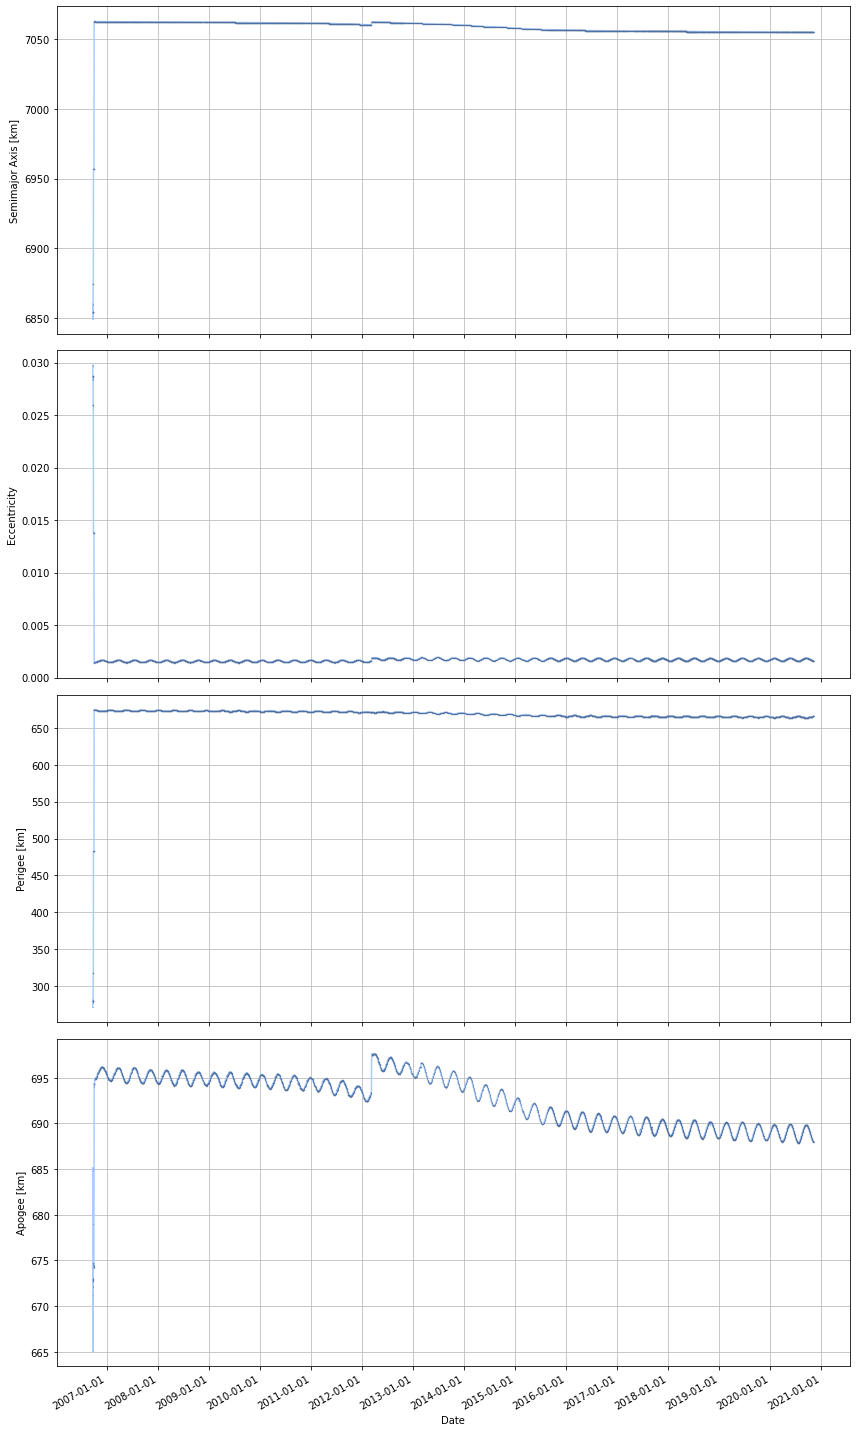

In [11]:
# 軌道長半径、離心率、近地点、遠地点の時間変化をプロット
fig = plt.figure(figsize=(12, 20))
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(df['EPOCH'], df['SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Semimajor Axis [km]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(df['EPOCH'], df['ECCENTRICITY'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.set_xlabel("Date")
ax2.set_ylabel("Eccentricity")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(df['EPOCH'], df['PERIAPSIS'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.set_xlabel("Date")
ax3.set_ylabel("Perigee [km]")
ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(df['EPOCH'], df['APOAPSIS'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax4.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax4.set_xlabel("Date")
ax4.set_ylabel("Apogee [km]")
ax4.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [12]:
# 軌道長半径の時間変化
oneday = pd.Timedelta(days=1)
DT = df['EPOCH'].diff() / oneday
DSEMIMAJOR_AXIS = df['SEMIMAJOR_AXIS'].diff() / DT

In [13]:
DSEMIMAJOR_AXIS.describe()

count      8406.000000
mean        -26.877517
std        7459.485619
min     -534796.064714
25%          -0.002437
50%          -0.001044
75%           0.000000
max      299999.999970
dtype: float64

In [14]:
(DT * 86400).describe()

count      8406.000000
mean      53014.359176
std       32758.197910
min           0.000863
25%       29507.124744
50%       47279.992464
75%       76834.193112
max      402766.039872
Name: EPOCH, dtype: float64

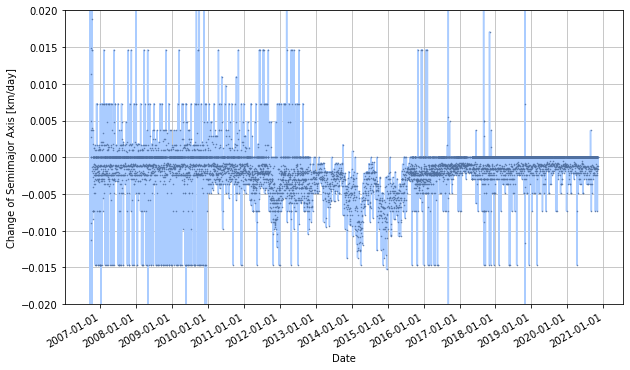

In [15]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH'], DSEMIMAJOR_AXIS, color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

ノイズが多くてよくわからないのでデータを間引く

In [16]:
# 1日平均と週平均 (EPOCHがインデックスになる)
df2 = df.resample('D', on='EPOCH').mean()
df3 = df.resample('W', on='EPOCH').mean()
print(len(df), len(df2), len(df3))

8407 5159 738


In [17]:
# 軌道長半径の時間変化
DSEMIMAJOR_AXIS2 = df2['SEMIMAJOR_AXIS'].diff()
DSEMIMAJOR_AXIS3 = df3['SEMIMAJOR_AXIS'].diff() / 7.0

In [18]:
DSEMIMAJOR_AXIS2.describe()

count    4734.000000
mean        0.042880
std         1.785637
min        -0.709556
25%        -0.002000
50%        -0.001000
75%        -0.000500
max       105.555000
Name: SEMIMAJOR_AXIS, dtype: float64

In [19]:
DSEMIMAJOR_AXIS3.describe()

count    737.000000
mean       0.038807
std        0.818654
min       -0.011524
25%       -0.002562
50%       -0.000957
75%       -0.000669
max       20.015167
Name: SEMIMAJOR_AXIS, dtype: float64

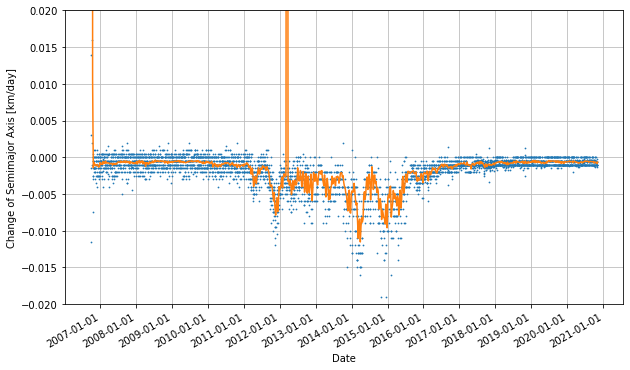

In [20]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df2.index, DSEMIMAJOR_AXIS2, '.', markersize=1.5)
ax1.plot(df3.index, DSEMIMAJOR_AXIS3)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

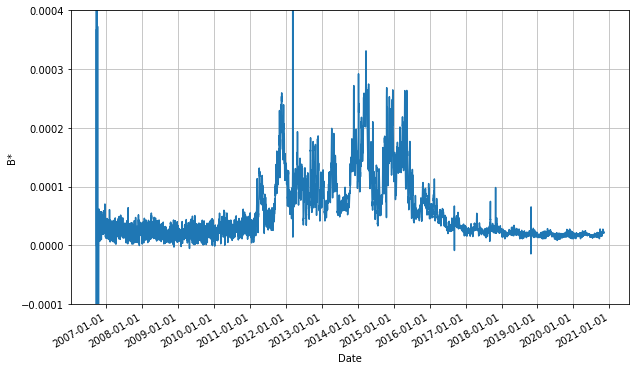

In [21]:
# 抗力項 BSTAR をプロット
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH'], df['BSTAR'])
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("B*")
ax1.set_ylim(-0.0001, 0.0004)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()